# Фаза 2 • Неделя 2 • Понедельник
## Компьютерное зрение
### Локализация объектов

#### Подготовим импорты

Из нового: 
1. `xml.etree.ElementTree` – с помощью него будем разбирать XML-файлы и доставать координаты bbox'ов 
2. `torchmetrics.functional.detection.iou` – чтобы вручную не считать IoU

In [73]:
import os
import xml.etree.ElementTree as ET
from glob import glob
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torch.nn.functional as F
import torchutils as tu
import torchvision.transforms as T
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional.detection.iou import intersection_over_union
from torchmetrics import Accuracy
from torchvision.models import ResNet18_Weights, resnet18, resnet50, ResNet50_Weights, resnet101, ResNet101_Weights, efficientnet_b0, efficientnet_b7
from torch.utils.tensorboard import SummaryWriter

#### XML-файлы

In [74]:
annotation = ET.parse('data/Veg/loc_train/cucumber_1.xml')

In [75]:
print(annotation)

In [76]:
annotation.find('object').find('bndbox').find('ymin').text

'42'

#### Подгтовим датасет

Он принимает на вход в конструктор 3 переменные: 
* `root_dir` – путь к обучающим/валидационным файлам (включая соответствующие xml-файлы)
* `image_size` – сразу определимся с размером картинок (у нас 227х227)
* `transform` – какие преобразования использовать для картинок (как минимум `ToTensor`, но обучающие будем аугментировать)

In [77]:
# type: ignore
class CustomDataset(Dataset):
    def __init__(
            self, 
            root_dir: str, 
            image_size: int = 227, 
            transform: T.Compose = T.Compose([])
            ):
        self.image_size = image_size
        self.root_dir: str = root_dir
        self.transform = transform
        # создаем два списка: с картинками и xml
        self.img_paths = sorted(glob(f'{self.root_dir}/*.jpg'))
        self.xml_paths = sorted(glob(f'{self.root_dir}/*.xml'))

        # делаем вспомогательные словари, чтобы из названий классов получать индексы
        self.cls2ix = {
            'cucumber' : 0, 
            'eggplant' : 1, 
            'mushroom' : 2
            }
        # и наоборот
        self.ix2cls = {v: k for k, v in self.cls2ix.items()}

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # по индексу находим в списке файлов аннотацию
        annotation = ET.parse(self.xml_paths[idx]) 
        # забираем название файла с картинкой
        filename = annotation.find('filename').text
        # открываем картинку
        image = Image.open(os.path.join(self.root_dir, filename)) 
        # преобразуем
        if self.transform:
            image = self.transform(image)
        # получаем название класса
        label = annotation.find('object').find('name').text 
        # преобразуем в индекс
        label = self.cls2ix[label]
        # получаем координаты настоящего бокса
        xmin = int(annotation.find('object').find('bndbox').find('xmin').text)
        ymin = int(annotation.find('object').find('bndbox').find('ymin').text)
        xmax = int(annotation.find('object').find('bndbox').find('xmax').text)
        ymax = int(annotation.find('object').find('bndbox').find('ymax').text)
        # конвертируем в тензор и масштабируем в диапазон [0-1]
        bbox = torch.Tensor((xmin, ymin, xmax, ymax)) / self.image_size
        return torch.tensor(label), bbox, image, filename

In [78]:
train_aug = T.Compose(
    [   
        
        T.GaussianBlur(kernel_size=(5, 9), sigma=(0.3, 5.)),
        T.Resize((227, 227)),
        T.ToTensor()
    ]
)
valid_aug = T.Compose(
    [   
        T.Resize((227, 227)),
        T.ToTensor()
    ]
)
train_dataset = CustomDataset(root_dir='data/Veg/loc_train', image_size=227, transform=train_aug)
valid_dataset = CustomDataset(root_dir='data/Veg/loc_valid', image_size=227, transform=valid_aug)

In [79]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [80]:
batch = next(iter(train_loader))
batch

[tensor([0, 1, 0, 1, 0, 2, 1, 0, 1, 2, 1, 1, 2, 0, 2, 0, 1, 2, 2, 2, 0, 0, 1, 0,
         0, 2, 1, 0, 0, 0, 2, 0]),
 tensor([[0.1101, 0.3084, 0.8855, 0.6432],
         [0.0661, 0.0176, 0.9471, 0.8150],
         [0.1410, 0.3260, 0.8811, 0.5815],
         [0.0352, 0.1366, 0.9648, 0.9692],
         [0.0352, 0.1674, 0.9648, 0.7930],
         [0.0969, 0.1101, 0.6608, 0.9559],
         [0.0837, 0.1850, 0.9383, 0.8194],
         [0.0485, 0.1366, 0.9559, 0.9163],
         [0.2819, 0.2115, 0.7313, 0.6520],
         [0.1850, 0.1057, 0.7930, 0.9383],
         [0.0837, 0.2159, 0.9251, 0.7445],
         [0.2467, 0.1542, 0.6388, 0.9339],
         [0.2423, 0.1322, 0.7357, 0.9339],
         [0.0925, 0.1278, 0.8899, 0.8722],
         [0.1410, 0.1894, 0.8502, 0.9163],
         [0.1366, 0.3216, 0.9207, 0.6256],
         [0.0220, 0.0529, 0.8370, 0.9207],
         [0.6432, 0.1982, 0.8678, 0.8943],
         [0.2643, 0.1938, 0.7181, 0.8634],
         [0.2379, 0.1145, 0.8150, 0.8458],
         [0.1630, 0.1101

# Модель 

В качестве экстрактора признаков будем использовать предобученный ResNet18, но отрежем последние два слоя: пулинг и полносвязный

In [81]:
feature_extractor = efficientnet_b7(pretrained = True)
feature_extractor

/home/zef-lx/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zef-lx/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [82]:
list(feature_extractor.children())

[Sequential(
   (0): Conv2dNormActivation(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
     (2): SiLU(inplace=True)
   )
   (1): Sequential(
     (0): MBConv(
       (block): Sequential(
         (0): Conv2dNormActivation(
           (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
           (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
           (2): SiLU(inplace=True)
         )
         (1): SqueezeExcitation(
           (avgpool): AdaptiveAvgPool2d(output_size=1)
           (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
           (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
           (activation): SiLU(inplace=True)
           (scale_activation): Sigmoid()
         )
         (2): Conv2dNormActivation(
           (0): Conv2d(64, 32, kernel_s

In [83]:
feature_extractor = efficientnet_b7(pretrained = True)

feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-2])
feature_extractor

Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(


In [84]:
feature_extractor(torch.randn(1, 3, 227, 227)).shape

torch.Size([1, 2560, 8, 8])

Задаем класс модели в соответствии со схемой: 
<img src="../slides/sources/aux/localization_model.png">

In [85]:
class LocModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.feature_extractor = resnet18(ResNet18_Weights)
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])
        # фризим слои, обучать их не будем (хотя технически можно)
        # for param in self.feature_extractor.parameters():
        #     param.requires_grad = False

        # for param in self.feature_extractor[7].parameters():
        #     param.requires_grad = True

        # задай классификационный блок
        self.clf = nn.Sequential(
            nn.Linear(512*8*8, 128),
            nn.Dropout(0.5),
            nn.Sigmoid(),
            nn.Linear(128, 3)
        )

        # задай регрессионный блок
        self.box = nn.Sequential(
            nn.Linear(512*8*8, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 4),
            nn.Sigmoid()
        )

    def forward(self, img):
        # задай прямой проход
        resnet_out = self.feature_extractor(img)
        resnet_out = resnet_out.view(resnet_out.size(0), -1)
        pred_classes = self.clf(resnet_out)
        pred_boxes = self.box(resnet_out)
        #print(pred_classes.shape, pred_boxes.shape)
        return pred_classes, pred_boxes

In [86]:
model = LocModel()
print(list(param.requires_grad for param in model.parameters()))
model(torch.randn(1, 3, 227, 227))

/home/zef-lx/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/zef-lx/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


(tensor([[ 0.3518, -0.2936, -0.2933]], grad_fn=<AddmmBackward0>),
 tensor([[0.4739, 0.5757, 0.2937, 0.1834]], grad_fn=<SigmoidBackward0>))

In [87]:
model = LocModel()
# проверь модель на батче: помни, что он возвращает tuple, оттуда нужно не всё
tu.get_model_summary(model, torch.randn(1, 3, 227, 227))

Layer                                                    Kernel             Output          Params           FLOPs
0_feature_extractor.Conv2d_0                           [3, 64, 7, 7]   [1, 64, 114, 114]       9,408   122,266,368
1_feature_extractor.BatchNorm2d_1                               [64]   [1, 64, 114, 114]         128     3,326,976
2_feature_extractor.ReLU_2                                         -   [1, 64, 114, 114]           0             0
3_feature_extractor.MaxPool2d_3                                    -     [1, 64, 57, 57]           0             0
4_feature_extractor.4.0.Conv2d_conv1                  [64, 64, 3, 3]     [1, 64, 57, 57]      36,864   119,771,136
5_feature_extractor.4.0.BatchNorm2d_bn1                         [64]     [1, 64, 57, 57]         128       831,744
6_feature_extractor.4.0.ReLU_relu                                  -     [1, 64, 57, 57]           0             0
7_feature_extractor.4.0.Conv2d_conv2                  [64, 64, 3, 3]     [1, 64,

#### Обучение

In [88]:
# этот блок можно оставить, а можно изменить и посмотреть на результат
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=.9)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 25])

CELoss = torch.nn.CrossEntropyLoss()
MSELoss = torch.nn.MSELoss()
ACC = Accuracy(task="multiclass", num_classes=3)

In [89]:
# создаем словарь для логов, 10 ключей (см. слайды)
log = dict()
log['epoch_train_clf_loss'] = []
log['epoch_valid_clf_loss'] = []
log['epoch_train_reg_loss'] = []
log['epoch_valid_reg_loss'] = []
log['epoch_train_total_loss'] = []
log['epoch_valid_total_loss'] = []
log['epoch_train_accuracy'] = []
log['epoch_valid_accuracy'] = []
log['epoch_train_iou'] = []
log['epoch_valid_iou'] = []

In [90]:
# writer = SummaryWriter('runs/experiment1')

In [91]:
for i in range(100):
    print(f'{"-"*13} Epoch {i + 1} {"-"*13}')

    batch_clf_loss = []
    batch_reg_loss = []
    batch_acc = []
    batch_iou = []
    batch_total_loss = []

    ####### обучающий шаг
    model.train()
    for true_label, true_box, image, filename  in train_loader:
               
        pred_class, pred_box = model(image)

        C_loss = CELoss(pred_class, true_label)
        LG_loss = MSELoss(pred_box, true_box)

        batch_clf_loss.append(C_loss.detach().numpy())
        batch_reg_loss.append(LG_loss.detach().numpy())
        batch_acc.append(ACC(pred_class,true_label))
        batch_iou.append(intersection_over_union(pred_box,true_box).detach().numpy())
        batch_total_loss.append(C_loss.detach().numpy() + LG_loss.detach().numpy())

        optimizer.zero_grad()
        (C_loss + LG_loss).backward()
        optimizer.step()

    log['epoch_train_clf_loss'].append(np.mean(batch_clf_loss))
    log['epoch_train_reg_loss'].append(np.mean(batch_reg_loss))
    log['epoch_train_total_loss'].append(np.mean(batch_total_loss))
    log['epoch_train_accuracy'].append(np.mean(batch_acc))
    log['epoch_train_iou'].append(np.mean(batch_iou))

    # writer.add_scalar('Loss/train', np.mean(batch_total_loss), i)
    # writer.add_scalar('Accuracy/train', np.mean(batch_acc), i)

    batch_clf_loss = []
    batch_reg_loss = []
    batch_acc = []
    batch_iou = []
    batch_total_loss = []

    ######### валидационный шаг
    model.eval()
    for true_label, true_box, image, filename  in valid_loader:
               
        with torch.no_grad():
            pred_class, pred_box = model(image)
        C_loss = CELoss(pred_class, true_label)
        LG_loss = MSELoss(pred_box, true_box)

        batch_clf_loss.append(C_loss)
        batch_reg_loss.append(LG_loss)
        batch_acc.append(ACC(pred_class,true_label))
        batch_iou.append(intersection_over_union(pred_box,true_box))
        batch_total_loss.append(C_loss + LG_loss)

    #########
    log['epoch_valid_clf_loss'].append(np.mean(batch_clf_loss))
    log['epoch_valid_reg_loss'].append(np.mean(batch_reg_loss))
    log['epoch_valid_total_loss'].append(np.mean(batch_total_loss))
    log['epoch_valid_accuracy'].append(np.mean(batch_acc))
    log['epoch_valid_iou'].append(np.mean(batch_iou))

    # реализуй логирование: можно обычными print, а можно подключить tensorboard
    print(
            f'train: accuracy {log['epoch_train_accuracy'][-1]:.4f}, clfloss {log['epoch_train_clf_loss'][-1]:.4f}, regloss {log['epoch_train_reg_loss'][-1]:.4f}, IoU {log['epoch_train_iou'][-1]:.4f}\n'
            f'valid: accuracy {log['epoch_valid_accuracy'][-1]:.4f}, clfloss {log['epoch_valid_clf_loss'][-1]:.4f}, regloss {log['epoch_valid_reg_loss'][-1]:.4f}, IoU {log['epoch_valid_iou'][-1]:.4f}'
        )
    print(f'{"-"*35}')
    print()
    #######

    lr_scheduler.step()

    # реализуй визуализацию: рандомная картинка из батча, настоящая рамка, предсказанная рамка. Используй cv2.Rectangle
    pass
    #######    

------------- Epoch 1 -------------
train: accuracy 0.4100, clfloss 1.0994, regloss 0.0683, IoU 0.3241
valid: accuracy 0.7969, clfloss 0.9307, regloss 0.0406, IoU 0.4304
-----------------------------------

------------- Epoch 2 -------------
train: accuracy 0.6687, clfloss 0.9279, regloss 0.0440, IoU 0.4020
valid: accuracy 0.4635, clfloss 1.0736, regloss 0.0316, IoU 0.4964
-----------------------------------

------------- Epoch 3 -------------
train: accuracy 0.7713, clfloss 0.8647, regloss 0.0302, IoU 0.4428
valid: accuracy 0.3385, clfloss 1.0471, regloss 0.0220, IoU 0.5365
-----------------------------------

------------- Epoch 4 -------------
train: accuracy 0.8625, clfloss 0.7201, regloss 0.0346, IoU 0.4101
valid: accuracy 0.6823, clfloss 0.8831, regloss 0.0217, IoU 0.5491
-----------------------------------

------------- Epoch 5 -------------
train: accuracy 1.0000, clfloss 0.6016, regloss 0.0262, IoU 0.4577
valid: accuracy 0.3229, clfloss 0.9583, regloss 0.0147, IoU 0.5774
--

In [92]:
torch.save(model, 'model.pth')
torch.save(model.state_dict(), 'model_weights.pth')

In [99]:
# import pickle as pkl

# with open('history.pkl','wb') as ifile:
#     pkl.dump(log, ifile) 

Визуализируй лоссы и метрики обучени на с помощью кривых обучения. Качество классифкации будет высоким, а вот IoU должен быть в интервале 0.5-0.6 – это слабая модель. 

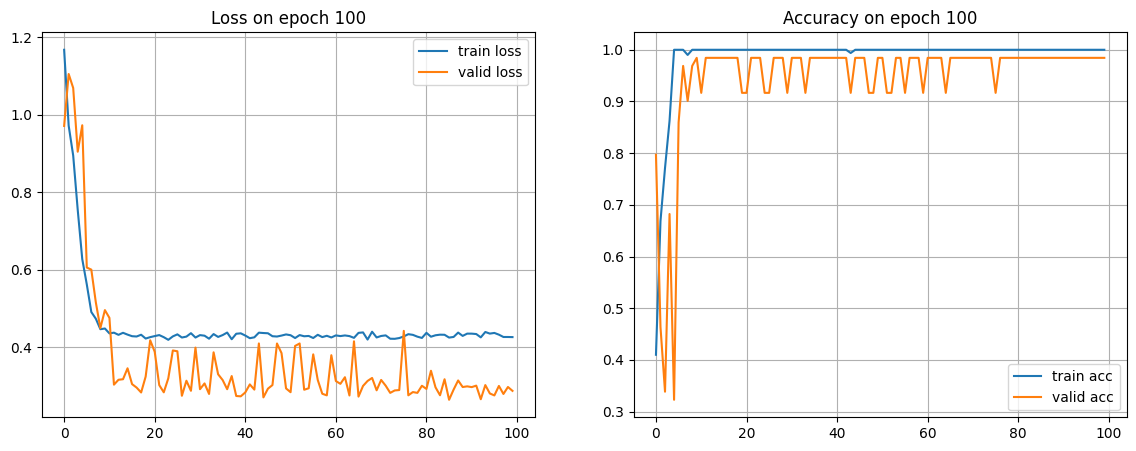

In [93]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
grid = True
ax[0].plot(log['epoch_train_total_loss'], label='train loss')
ax[0].plot(log['epoch_valid_total_loss'], label='valid loss')
ax[0].set_title(f'Loss on epoch {len(log['epoch_train_total_loss'])}')
ax[0].grid(grid)
ax[0].legend()

ax[1].plot(log['epoch_train_accuracy'], label='train acc')
ax[1].plot(log['epoch_valid_accuracy'], label='valid acc')
ax[1].set_title(f'Accuracy on epoch {len(log['epoch_valid_total_loss'])}')
ax[1].grid(grid)
ax[1].legend()

plt.show()

In [94]:
true_label, true_box, image, filename = next(iter(valid_loader))
model.eval()
with torch.no_grad():
    pred_class, pred_box = model(image)

In [95]:
image[0].shape

torch.Size([3, 227, 227])

In [96]:
l = list(true_box[0].numpy() * 227)
coord = [(l[0],l[1]), (l[2],l[3])]

l2 = list(pred_box[0].numpy() * 227)
coord2 = [(l2[0],l2[1]), (l2[2],l2[3])]

img = image[0].permute(1, 2, 0)


In [97]:
img.shape

torch.Size([227, 227, 3])

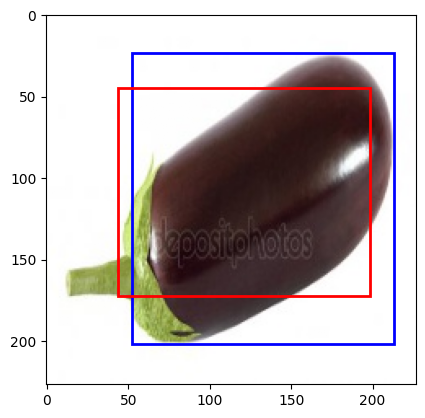

In [98]:
# Определите координаты и размеры рамки
xt, yt = (l[0],l[1])  # координаты верхнего левого угла квадрата
width1 = l[2] - l[0]    # ширина и высота квадрата (так как он квадратный)
width2 = l[3] - l[1]

xp, yp = (l2[0],l2[1])
width3 = l2[2] - l2[0]    # ширина и высота квадрата (так как он квадратный)
width4 = l2[3] - l2[1]
# Создайте фигуру и оси
fig, ax = plt.subplots()

# Показать изображение
ax.imshow(img)

# Создайте квадратную рамку
rect_true = patches.Rectangle((xt, yt), width1, width2, linewidth=2, edgecolor='b', facecolor='none')
rect_pred = patches.Rectangle((xp, yp), width3, width4, linewidth=2, edgecolor='r', facecolor='none')

# Добавьте квадратную рамку на оси
ax.add_patch(rect_true)
ax.add_patch(rect_pred)

# Покажите результат
plt.show()